# Лабораторная работа 4. Часть 2. Рекомендательные системы.



Результат лабораторной работы − отчет. Мы предпочитаем принимать отчеты в формате ноутбуков IPython (ipynb-файл). Постарайтесь сделать ваш отчет интересным рассказом, последовательно отвечающим на вопросы из заданий. Помимо ответов на вопросы, в отчете так же должен быть код, однако чем меньше кода, тем лучше всем: нам − меньше проверять, вам — проще найти ошибку или дополнить эксперимент. При проверке оценивается четкость ответов на вопросы, аккуратность отчета и кода.


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 8 баллов. Сдавать задание после указанного в lk срока сдачи нельзя. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов и понижают карму (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий в открытом источнике, необходимо прислать ссылку на этот источник (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, нам необходима ссылка на источник).



## Знакомство с данными

### Рекомендация организаций, которые получат высокий отзыв от пользователя, когда он гостит в чужом для себя городе

Эта лабораторная работа про задачу из соревнования

https://contest.yandex.ru/contest/36927/problems/


**(1 балла) Задание 1.** Знакомство с данными.

В первую очередь нам понадобятся данные по __пользователям__ (в терминах recsys -- users), __организациям__ (в терминах recsys -- items) и сами __отзывы__ (в терминах recsys -- ratings или explicit feedback). 

На основании этих данных можно будет проводить базовый анализ методами колаборативной фильтрации.

  * Опишите, насколько активно пользователи оставляют отзывы, насколько активно организации получают отзывы.
  * Предложите стратегии фильтрации данных.
  


Во вторую очередь нас будут интересовать атрибуты организаций: aspects, features, rubrics.
Проанализируйте эти таблицы. Какие признаки для описания организаций и пользователей из них можно извлечь?


In [549]:
%load_ext nb_black

import abc
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from functools import partial

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [136]:
def read_ints(line):
    return list(map(int, line.split()))


def read_data(
    path="data/*.csv",
    converters={"rubrics_id": read_ints, "features_id": read_ints},
    index_col=0,
):
    data = {}
    for csv_filename in glob.glob(path):
        basename, extension = os.path.splitext(os.path.basename(csv_filename))
        data[basename] = pd.read_csv(
            csv_filename,
            converters=converters,
            index_col=index_col,
        )
    return data

<IPython.core.display.Javascript object>

In [141]:
data = read_data()
users = data["users"]
organisations = data["organisations"]
reviews = data["reviews"].reset_index()

/tmp/ipykernel_35045/1278097623.py:16: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  data[basename] = pd.read_csv(


<IPython.core.display.Javascript object>

* Опишите, насколько активно пользователи оставляют отзывы, насколько активно организации получают отзывы.

In [488]:
def describe_review_counts(
    df,
    reviews,
    axis,
    title,
    quantiles=(0, 0.25, 0.5, 0.75, 0.90, 0.95, 0.99, 0.999, 0.9999, 1),
    quantiles_to_plot=(0.5, 0.99, 0.999, 0.9999),
    plt_kwargs=None,
    cmap="hsv",
):
    reviews_count = reviews.groupby(df.index.name).size().reindex(df.index)
    reviews_count.plot(ax=axis, title=title, **(plt_kwargs or {}))
    axis.set_xlabel(plt_kwargs.get("xlabel"))
    axis.set_ylabel(plt_kwargs.get("ylabel"))

    for i, q in enumerate(quantiles_to_plot, start=1):
        quantile = reviews_count.quantile(q=q)
        axis.axvline(quantile, ls="--", c=plt.get_cmap(name=cmap)(q))
        axis.text(quantile, axis.get_ylim()[1] / 2**i, f"{100*q}%", ha="left")

    return reviews_count.agg(
        {
            "mean": pd.Series.mean,
            "std": pd.Series.std,
            **{f"{100*q}%": partial(pd.Series.quantile, q=q) for q in quantiles},
        }
    )


def show_review_counts(users, organisations, reviews):
    fig, axes = plt.subplots(ncols=2, figsize=(16, 6))
    plt_kwargs = dict(
        kind="hist",
        log=True,
        histtype="stepfilled",
        bins=100,
        edgecolor="black",
        facecolor="gray",
        alpha=0.5,
        xlabel="Reviews count",
        ylabel="Frequency (log scale)",
    )
    return pd.DataFrame(
        {
            title: describe_review_counts(
                df,
                reviews,
                axis,
                title=title,
                plt_kwargs=plt_kwargs,
            )
            for df, axis, title in zip(
                [users, organisations],
                axes,
                ["Users reviews written", "Organisations reviews received"],
            )
        }
    ).T

<IPython.core.display.Javascript object>

,mean,std,0%,25.0%,50.0%,75.0%,90.0%,95.0%,99.0%,99.9%,99.99%,100%
Users reviews written,2.964589,4.854616,1.0,1.0,1.0,3.0,6.0,10.0,22.0,54.000,117.0000,611.0
Organisations reviews received,60.429564,436.475347,1.0,2.0,8.0,32.0,125.0,246.0,785.0,3021.324,15019.8882,61520.0


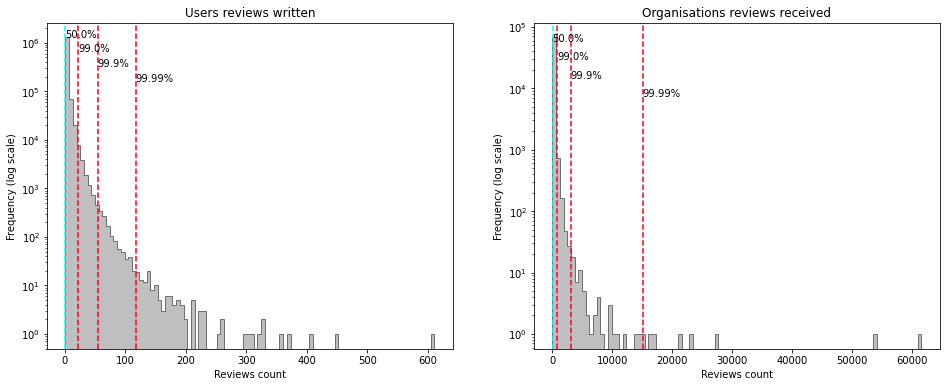

<IPython.core.display.Javascript object>

In [489]:
show_review_counts(users, organisations, reviews)

* Предложите стратегии фильтрации данных.

Отбросить организации, у которых мало оценок и все они негативные. Это наименее полезные для нас организации, поскольку они одновременно не дают много информации о взаимных интересах пользователей, и не пригодятся для конечных рекомендаций.

Реализация этой стратегии может выглядеть так: мы сортируем организации по значению функции полезности

$$f(\text{organisation}) = (\text{rating count})(1 + \text{rating std})^\alpha (\text{mean rating})^\beta$$

И отсекаем $\gamma$ первых организаций, где $\alpha, \beta$ и $\gamma$ подбираются по нашим предпочтениям.

* Во вторую очередь нас будут интересовать атрибуты организаций: aspects, features, rubrics. Проанализируйте эти таблицы. Какие признаки для описания организаций и пользователей из них можно извлечь?

Эти таблицы содержат текстовые описания, так что можно взять их эмбединги или обучить латентные векторные представления, либо кластеризовать и взять метки кластеров, и использовать все это в качестве дополнительных признаков.

---

**(1 балла) Задание 2.** Организация валидации.

Как вы помните, обучающее множество собрано за X = 1277 дней, тестовое множество – за последующие Y = 107 дней.

Следовательно нам необходимо организовать у себя валидацию схожим образом.
Раз мы будем еще и осуществлять выбор моделей, то следует произвести расщепление по времени на 3 группы train validation и holdout.

Как уже говорилось на семинаре, для повышения качества локальной валидации, можно сделать скользящую валидацию. В самой лабораторной работе мы так делать не будем, но для конкурса имейте это в виду.


In [546]:
def split_by_column(df, sizes, column_name):
    cumulative_sizes = np.cumsum([0] + sizes)
    split_edges = [int(s * len(df)) for s in cumulative_sizes]
    sorted_df = df.sort_values(column_name)
    splits = [sorted_df[b:e] for b, e in zip(split_edges, split_edges[1:])]
    return splits

<IPython.core.display.Javascript object>

In [539]:
review_splits = split_by_column(reviews, sizes=[0.7, 0.15, 0.15], column_name="ts")

<IPython.core.display.Javascript object>

**(0.5 балла) Задание 3.** Базовые решения.

Сделаем базовые решения:
  * Для каждого пользователя выдаём 20 случайных организаций
  * Для каждого пользователя выдаём самые популярные организации в неродном городе

In [609]:
class Predictor(abc.ABC):
    def __init__(self, users, organisations, reviews, predict_size=20):
        self.users = users
        self.organisations = organisations
        self.reviews = reviews
        self.predict_size = predict_size
        self.setup()

    def setup(self):
        ...

    @abc.abstractmethod
    def predict(self, user_ids):
        ...


class RandomPredictor(Predictor):
    def predict(self, user_ids):
        return np.random.choice(
            self.organisations.index, size=(len(user_ids), self.predict_size)
        )


class PopularPredictor(Predictor):
    def setup(self):
        self.popular_foreign_organisations_for_home_city = {}
        organisations = self.organisations.join(
            self.reviews.groupby("org_id").size().rename("popularity")
        )
        for city in organisations["city"].unique():
            self.popular_foreign_organisations_for_home_city[city] = (
                organisations.query(f"city != '{city}'")
                .sort_values("popularity", ascending=False)
                .index[: self.predict_size]
                .to_numpy()
            )

    def predict(self, user_ids):
        return (
            self.users.loc[user_ids]["city"]
            .map(self.popular_foreign_organisations_for_home_city)
            .values
        )

<IPython.core.display.Javascript object>

**(1.0 балла) Задание 4.** Метрики качества.

Напомним, что у нас бинарная релевантнотсь на основе оценки вычисляется как предикат **оценка больше, чем 3**.

Реализуйте набор метрик качества (можете оборачивать внешние паекты):

    * MNAP@20 (как в описании соревнования)
    * HitRate ( = 1, если среди рекомендаций есть хотя бы одна релевантная и 0 иначе)
    * MRR@20 ( обратная позиция первой релевантной рекомендации из списка рекомендаций длины K. )
    * Coverage (доля item-ов, учитываемых в рекомендациях)
    * Surprisal(см. ниже) 


### Surprisal
Посмотирм, насколько наши рекомендации хороши с точки зрения новизны для пользователя, в качестве новизны будем рассматривать "непопулярность" айтемов в рекомендациях.

Будем рассматривать собственную информацию item-а как меру его новизны.

$$selfInformation(i) = -\log_2 \frac{|u_i|}{|N|}$$, 
где 
$i$ - объект, $|N|$ - число взаимодействий в обучающей выборке,  $|u_i|$ - число пользователей, взаимодействовавших с объектом в обучающей выборке.

После подсчета собственной информации усредним значения собственной информации в рекомендациях пользователя.

Чтобы получить значения от 0 до 1, разделим значение метрики для пользователя на максимально возможно значение метрики равное $log_2 N$.

$$Surprisal(u)@k = \frac{1}{k \cdot log_2 N} \sum_{j = 1}^{k}selfInformation(i_{u,j})$$

где $i_{u,j}$ это j-й объект, который мы порекомендововали пользователю.

Получившаяся метрика похожа на энтропию Шеннона:
$$H = - K \sum_{i\in R}{p_i log p_i}$$


Результа усредним по пользователям.

### Что нужно сделать
    
  * Создайте функцию, которая генерирует словарь с метриками, по предоставленному решению.

  * Оцените baseline-решения на валидации.

In [613]:
reviews.head()

,user_id,org_id,rating,ts,aspects
0,5969205021826098131,15999570556361329805,1.0,279,NaN
1,11419028914633614269,15999570556361329805,1.0,391,NaN
2,11971839180212507821,15999570556361329805,1.0,419,NaN
3,3849350083734153986,15999570556361329805,1.0,641,NaN
4,6903065064138938065,15999570556361329805,1.0,654,NaN


<IPython.core.display.Javascript object>

In [612]:
df.groupby("city").loc[0]

AttributeError: 'DataFrameGroupBy' object has no attribute 'loc'

<IPython.core.display.Javascript object>

In [645]:
class Metrics:
    def __init__(self, users, organisations, reviews):
        self.users = users
        self.organisations = organisations
        self.reviews = reviews

    def precision(self, user_id, org_ids):
        return self.reviews.query(
            "user_id == @user_id and org_id in @org_ids and rating > 3"
        ).sum()["rating"]

    def precision_at_k(self, user_ids, predicted_org_ids, k=20):
        f = pd.DataFrame(data=predicted_org_ids, index=user_ids)
        return (
            self.reviews.query("user_id in @user_ids")
            .groupby("user_id")
            .apply(lambda s: self.precision(user_id=s.name, org_ids=f.loc[s.name]) / k)
        )

<IPython.core.display.Javascript object>

In [646]:
pd.DataFrame(data=rp.predict(users.index[:10]), index=users.index[:10])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
user_id,,,,,,,,,,,,,,,,,,,,
12735004856856244189,9260840547554909025,4615799622420927129,1303045138753861621,4002753953944129496,7104328276125685835,18116244555659362135,1880901118707220512,2601780510113097923,15968435144720843186,16944290901644877442,11387625357803259538,5468520444917306480,182413508746714285,14902177973430159180,12522794382580654618,11002324904831433345,8687621888167902242,4419887685123091374,6598986148730224003,8852967842776189876
13776338520332531455,16791460456395829217,11130180254698225265,8156428698669917781,11675672831319118789,17271649915503956113,99952334861167038,5318827681994980342,15788038873305572283,8063308152186038401,2779241192918786786,16159958173526955153,12509029874365286967,5143511808683667744,1216794336764645534,3100234922139091489,14134382852043588333,13531272106260890169,5780863577158557749,13025342072003194122,14169958441648324877
15114084219042454101,3380087438329507031,3259749978605368748,9852271494117177473,12271531267702780049,8850033725933040204,4863583757604419932,9338388301824389985,12919490193946104588,9343124961673809578,9662774112195933822,5451705875141791218,8654868747871321493,791998485180798243,14247701012006193422,11820483642743212896,12458691864921036268,15092343549189553915,11868268526799586973,12347855685695338081,6525676573853076053
18069716857179407490,2819398444444116130,1733270427946127720,15026756333764794914,11412958104991634464,8314234182732445928,1735113669228771876,18017430857209797812,14158337895066800891,16738494661977560638,5299157254090994579,15744459916273398897,8189881073973857504,17370885386271216584,5020319261206858544,12592813891048138707,7178342793001686237,18318069631309144938,10763288711966091546,8526398446705228815,12239343030849204437
4630864276989162245,5597851748398359526,1403416195891798320,10970766495739143184,4772308481469816652,3052647463699248556,3799503880627864924,7509033045150730522,1151323008464007132,3308598328784931897,13356235993799858731,3440876668335826733,16030380420517162209,5565212466723916670,13929686789925465899,2639839453692403367,15223181333289983253,12686335177729025380,9914948735140068958,14242930151936847013,8474184705792214793
11617835983188089768,13246399462016188906,16571714021774948464,6509745257993182777,5001176799655644755,3283785957266768933,7990258152090303610,9341266069716498760,6248806338696616554,13702117328106227922,11615933181637341662,385072876382483311,1337021233643201200,17662684569129497551,14166061749012467549,4594995631498172557,3902298890690882052,15155915354348211429,10540089170084709760,10773635972175557166,6103288811264462886
1185256209442259691,2302285924455863221,5028742492672782332,13049002570367234443,16396969280951334654,10733798018660904490,7229603085107028835,11000179435440900296,5106143874954303418,17800837000387284156,744036470111047009,16759886567194945979,7566865111629958743,9487570289861360697,9661210068147375242,12525058062637005689,18394985943028441578,12847812175112564056,910959202343143525,12799204370062962650,9688391855878766376
1463199750889852452,4699428119149200971,14912662191875735302,15659601663243386617,13071234225828095599,14686126202289057034,5344832325402901137,1074064351548346486,15256153359639617367,2403885380017810798,11780169929305427606,360821951181138013,11507269645148418409,11178463605298814265,6220592967630999435,13397813214991677926,3583713498496685099,3954455331724398066,17692417024390216349,11336810404070521522,7369809619043082253
1538227614427260888,7869850598313299445,4304650225750731072,6608759296710873949,244779322420052840,4152703346489197022,8351821597044895231,15874911053452839758,8705397074068895641,16580509435714570513,16321096502682161517,2965926843429217789,467724322566227921,13914247086705100430,8658592039859823969,3468526851963413308,2405535805849142785,2750970103745443082,10363654306035071799,837091301665483099,2587149256903699605


<IPython.core.display.Javascript object>

In [649]:
reviews.query("user_id == 1185256209442259691")

,user_id,org_id,rating,ts,aspects
727394,1185256209442259691,8963203803572992507,5.0,505,NaN
3266072,1185256209442259691,6273273006771493206,5.0,488,NaN


<IPython.core.display.Javascript object>

In [650]:
rp.predict([1185256209442259691])

array([array([11006800892303205642,  1732348878070501516,  1352900198295267165,
               4477853013398754244, 15445427435171105618,  4899586129781774940,
              14378098879624719559,  8187133161650776223,  3520821398830349226,
               7244033762487689492, 17239524486607140551,   789253580523133408,
               1463651751421197399,  7182333458821469276, 16515799056215097281,
              11710076672100157355, 17707727234326305172,  5473783084203318304,
              13003865947605611631, 14780417735296018091], dtype=uint64)       ],
      dtype=object)

<IPython.core.display.Javascript object>

In [651]:
metrics = Metrics(users, organisations, reviews)
rp = RandomPredictor(users, organisations, reviews)
rp = PopularPredictor(users, organisations, reviews)
users_ids = users.index[:1000]
metrics.precision_at_k(users_ids, rp.predict(users_ids)).describe()

count    100.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
dtype: float64

<IPython.core.display.Javascript object>

**(1.0 балла) Задание 5.** Метод Memory based. User-2-User or Item-2-Item

Теперь рассмотрим [memory-based](https://en.wikipedia.org/wiki/Collaborative_filtering#Memory-based) методы рекоммендаций.
Подход, лежащий в их основе, использует данные о рейтингах для вычисления сходства между пользователями (user-based) или объектами (item-based), на основе этих данных делаются предсказания рейтингов и, в дальнейшем, строятся рекоммендации. Эти методы просты в реализации и эффективны на ранних стадиях разработки рекомендательных систем.
                                 
              
За последние годы было создано много библиотек для реализации алгоримтов построения рекомендаций.      
  * https://github.com/benfred/implicit
  * https://sberbank-ai-lab.github.io/RePlay/index.html
  * https://github.com/apple/turicreate 
  * https://github.com/caserec/CaseRecommender

Выеберите одну из них и постройте предсказания на основании совместной фильтрации по близости пользователей или по близости объектов.

Если обучение идёт слишком долго подумайте про семплирование данных. Обоснуйте выбранную стратегию семплирования.



## Методы Matrix factorization

**(0.5 балла) Задание 6.**

- Разложите матрицу рейтингов с помощью [разреженного SVD](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) и, восстановив ее, получите предсказания рейтингов для всех пар пользователь-объект. В данном случае неизвестные рейтинги заполняются нулями, а затем восстанавливаются с помощью SVD (этот метод называется PureSVD).
   * Получив векторные представления пользователей и объектов и сингулярные числа, мы можеи восстановив матрицу и в местах нулей получим "предсказанные значения вероятностей" для новых объектов.
- Рассмотрите, как минимум, 5 различных значений ранга разложения. Оцените качество рекомендаций

# ALS
Довольно популярным базовым методом в рекомендательных системах является ALS.

### Explicit ALS

Релевантность:
$$r_{ui} = q_i^T p_u$$

Loss:
$$\min_{p*, q*} \sum_{(u, i \in \mathcal{K})} (r_{ui} - q_i^T p_u)^2 + \lambda(\|{q_i}\|^2 + \|{p_i}\|^2)$$

### [Implicit ALS](http://yifanhu.net/PUB/cf.pdf)

Релевантность:
$$r_{ui} = q_i^T p_u$$

Loss:
$$\min_{p*, q*} \sum_{(u, i \in \mathcal{K})} c_{ui}(p_{ui} - q_i^T p_u)^2 + \lambda(\|{q_i}\|^2 + \|{p_i}\|^2)$$
Где $c_{ui}$ - значение в матрице implicit feedback, а $p_{ui}$ равно 1, если пользователь u взаимодействовал с item-ом i, и 0 иначе.

### Усложнения ALS
Обучив для каждого пользователя и объекта свой bias и добавив регуляризацию можно улучшить качество решения. Подробнее о различных матричных разложениях для задачи рекомендаций можно почитать [в статье на Хабре](https://habr.com/ru/post/486802/).

В рейтинг объекта для пользователя, например, может быть представлен:
$$r_{ui} = \mu + b_i + b_u + q_i^T p_u$$

А функция потерь будет выглядеть так:
$$\min_{b*, p*, q*} \sum_{(u, i \in \mathcal{K})} (r_{ui} - \mu - b_i - b_u - q_i^T p_u)^2 + \lambda(\|{q_i}\|^2 + \|{p_i}\|^2 + b_i^2 + b_u^2)$$

Матричная факторизация - хороший подход, который позволяет получить рекомендации для теплых пользователей, а также находить похожих пользователей и объекты, посчитав расстояния между векторами. Обучив модель и получив вектора можно перейти от задачи рекомендаций к задаче поиска ближайших соседей и использовать ANN-методы.

**(1.0 балла) Задание 7.**
Примените ALS.

Можно воспользоваться готовой реализацией из бибилотеки https://github.com/benfred/implicit

Попробуйте использовать как все оценки, так и только высокие. Есть ли разница?

**(1.0 балла) Задание 8.**

На [семинаре](https://github.com/monkey0head/recsys_sem) Вам было расказано про бибилиотеку LightFM.
Примените ее для нашей задачи. Используя фичи и не используя фичи, сравните результат.

**(1.0 балла) Задание 9.**

   Посмотрим на все прошлые методы как на модели, которые генерируют нам кандидатов для ответа рекомендательной системы. 
   
   Как нам выбрать те 20 организаций наилучшим образом? 
   
   Давайте подключим машинное обучение. Сформулируем задачу ранжирования: запросом будет пользователь. Документами будут организации. Наивным признаковым описанием будет, например, факт рекомендации данной организации или скор/ранг от моделей SVD, ALS, LightFM.
   Примените catboost/xgboost/lightgbm для создания переранжирования рекомендаций. То есть сделаем двухуровневую модель. Выясните наиболее важные признаки моделей первого уровня.